In [ ]:
# ╔═══════════════════════════════════════════════════════════════════════════╗
# ║  CELL 1: IMPORTS & CONFIGURATION                                          ║
# ╚═══════════════════════════════════════════════════════════════════════════╝

print("=" * 90)
print("CELL 1: IMPORTS & CONFIGURATION")
print("=" * 90)

import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm
from collections import defaultdict, Counter
import json
import time
import warnings
warnings.filterwarnings('ignore')
import logging
logging.getLogger('rasterio').setLevel(logging.ERROR)

# ─────────────────────────────────────────────────────────────────────────────
# CONFIGURATION
# ─────────────────────────────────────────────────────────────────────────────

# Paths
DATASET_ROOT = "/content/drive/MyDrive/Dataset"
SAVE_DIR = "/content/drive/MyDrive/Pakistan_Models_v4"
CHECKPOINT_PATH = None  # Set to resume

# Training config - IMPROVED
NUM_EPOCHS = 50  # More epochs
BATCH_SIZE = 32
LEARNING_RATE = 5e-5  # Lower LR for better convergence
IMAGE_SIZE = (64, 64)
NUM_WORKERS = 2

# Temporal config
NUM_BANDS = 4
NUM_MONTHS = 6
NUM_CHANNELS = NUM_MONTHS * NUM_BANDS  # 24 channels

# Classes
CLASS_NAMES = ['Other', 'Rice', 'Wheat']
NUM_CLASSES = 3
CLASS_TO_IDX = {name: idx for idx, name in enumerate(CLASS_NAMES)}
IDX_TO_CLASS = {idx: name for idx, name in enumerate(CLASS_NAMES)}

# Months per class
MONTHS_BY_CLASS = {
    'Rice': ['May', 'Jun', 'Aug', 'Sep', 'Oct', 'Nov'],
    'Wheat': ['Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr'],
    'Other_Rice': ['May', 'Jun', 'Aug', 'Sep', 'Oct', 'Nov'],
    'Other_Wheat': ['Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr'],
}

# ─────────────────────────────────────────────────────────────────────────────
# NEW HYPERPARAMETERS FOR V4
# ─────────────────────────────────────────────────────────────────────────────
LABEL_SMOOTHING = 0.1  # Reduces overconfidence
MIXUP_ALPHA = 0.2  # Mixup augmentation strength
USE_RESNET34 = True  # Larger model
DROPOUT_RATE = 0.4  # Slightly lower dropout
WEIGHT_DECAY = 0.03  # Stronger regularization

print(f"\n✓ Configuration loaded (V4 IMPROVED)")
print(f"  Dataset: {DATASET_ROOT}")
print(f"  Save dir: {SAVE_DIR}")
print(f"  Classes: {CLASS_NAMES}")
print(f"  Input channels: {NUM_CHANNELS}")
print(f"  Epochs: {NUM_EPOCHS}")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Label smoothing: {LABEL_SMOOTHING}")
print(f"  Mixup alpha: {MIXUP_ALPHA}")
print(f"  Model: {'ResNet34' if USE_RESNET34 else 'ResNet18'}")


CELL 1: IMPORTS & CONFIGURATION

✓ Configuration loaded (V4 IMPROVED)
  Dataset: /content/drive/MyDrive/Dataset
  Save dir: /content/drive/MyDrive/Pakistan_Models_v4
  Classes: ['Other', 'Rice', 'Wheat']
  Input channels: 24
  Epochs: 50
  Learning rate: 5e-05
  Label smoothing: 0.1
  Mixup alpha: 0.2
  Model: ResNet34


In [ ]:
# ╔═══════════════════════════════════════════════════════════════════════════╗
# ║  CELL 2: MOUNT DRIVE & INSTALL DEPENDENCIES                               ║
# ╚═══════════════════════════════════════════════════════════════════════════╝

print("\n" + "=" * 90)
print("CELL 2: MOUNT DRIVE & INSTALL DEPENDENCIES")
print("=" * 90)

from google.colab import drive
drive.mount('/content/drive', force_remount=False)

try:
    import rasterio
    print("\n✓ rasterio already installed")
except ImportError:
    print("\nInstalling rasterio...")
    os.system("pip install -q rasterio")
    import rasterio
    print("✓ rasterio installed")

try:
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import confusion_matrix, classification_report, f1_score
    print("✓ sklearn already installed")
except ImportError:
    os.system("pip install -q scikit-learn")
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import confusion_matrix, classification_report, f1_score
    print("✓ sklearn installed")

assert os.path.exists(DATASET_ROOT), f"Dataset not found: {DATASET_ROOT}"
os.makedirs(SAVE_DIR, exist_ok=True)

print(f"\n✓ Dataset found: {DATASET_ROOT}")
print(f"✓ Save directory ready: {SAVE_DIR}")



CELL 2: MOUNT DRIVE & INSTALL DEPENDENCIES
Mounted at /content/drive

✓ rasterio already installed
✓ sklearn already installed

✓ Dataset found: /content/drive/MyDrive/Dataset
✓ Save directory ready: /content/drive/MyDrive/Pakistan_Models_v4


In [ ]:
# ╔═══════════════════════════════════════════════════════════════════════════╗
# ║  CELL 3: COLLECT AND ORGANIZE FILES                                       ║
# ╚═══════════════════════════════════════════════════════════════════════════╝

print("\n" + "=" * 90)
print("CELL 3: COLLECT AND ORGANIZE FILES")
print("=" * 90)

def get_months_for_sample(class_name, location_id):
    """Get correct month order for a sample."""
    if class_name == 'Rice':
        return MONTHS_BY_CLASS['Rice']
    elif class_name == 'Wheat':
        return MONTHS_BY_CLASS['Wheat']
    elif class_name == 'Other':
        try:
            id_num = int(location_id)
            if id_num <= 50:
                return MONTHS_BY_CLASS['Other_Wheat']
            else:
                return MONTHS_BY_CLASS['Other_Rice']
        except:
            return MONTHS_BY_CLASS['Other_Rice']
    return MONTHS_BY_CLASS['Rice']

def parse_filename(filename):
    """Parse filename: Class_ID_Month.tif"""
    name = filename.replace('.tif', '').replace('.TIF', '')
    parts = name.split('_')
    if len(parts) >= 3:
        cls = parts[0].capitalize()
        loc_id = parts[1]
        month = parts[-1].capitalize()
        return cls, loc_id, month
    return None, None, None

# Collect samples
all_samples = defaultdict(lambda: {'class': None, 'files': {}, 'year': None, 'loc_id': None})

print("\nScanning dataset...")
for class_name in CLASS_NAMES:
    class_path = os.path.join(DATASET_ROOT, class_name)
    if not os.path.exists(class_path):
        continue

    for year in ['2023', '2024']:
        year_path = os.path.join(class_path, year)
        if not os.path.exists(year_path):
            continue

        files = [f for f in os.listdir(year_path) if f.lower().endswith('.tif')]
        for f in files:
            cls, loc_id, month = parse_filename(f)
            if cls is None:
                continue

            sample_key = f"{class_name}_{year}_{loc_id}"
            all_samples[sample_key]['class'] = class_name
            all_samples[sample_key]['year'] = year
            all_samples[sample_key]['loc_id'] = loc_id
            all_samples[sample_key]['files'][month] = os.path.join(year_path, f)

print(f"\n✓ Total samples: {len(all_samples)}")

class_counts = Counter([s['class'] for s in all_samples.values()])
print(f"\nBy class:")
for cls, count in sorted(class_counts.items()):
    print(f"  {cls}: {count}")



CELL 3: COLLECT AND ORGANIZE FILES

Scanning dataset...

✓ Total samples: 616

By class:
  Other: 200
  Rice: 216
  Wheat: 200


In [ ]:
# ╔═══════════════════════════════════════════════════════════════════════════╗
# ║  CELL 4: FILTER & CREATE SPLITS                                           ║
# ╚═══════════════════════════════════════════════════════════════════════════╝

print("\n" + "=" * 90)
print("CELL 4: FILTER & CREATE SPLITS")
print("=" * 90)

MIN_MONTHS = 5

filtered_samples = {k: v for k, v in all_samples.items() if len(v['files']) >= MIN_MONTHS}
print(f"\n✓ Samples with {MIN_MONTHS}+ months: {len(filtered_samples)}")

class_counts_filtered = Counter([s['class'] for s in filtered_samples.values()])
print(f"\nBy class (filtered):")
for cls, count in sorted(class_counts_filtered.items()):
    print(f"  {cls}: {count}")

# Stratified split
samples_by_class = defaultdict(list)
for key, data in filtered_samples.items():
    samples_by_class[data['class']].append(key)

train_keys, val_keys, test_keys = [], [], []

print(f"\nCreating 70/15/15 splits...")
for cls, keys in samples_by_class.items():
    train_k, temp_k = train_test_split(keys, test_size=0.3, random_state=42)
    val_k, test_k = train_test_split(temp_k, test_size=0.5, random_state=42)

    train_keys.extend(train_k)
    val_keys.extend(val_k)
    test_keys.extend(test_k)

    print(f"  {cls}: train={len(train_k)}, val={len(val_k)}, test={len(test_k)}")

print(f"\n✓ Total: train={len(train_keys)}, val={len(val_keys)}, test={len(test_keys)}")



CELL 4: FILTER & CREATE SPLITS

✓ Samples with 5+ months: 616

By class (filtered):
  Other: 200
  Rice: 216
  Wheat: 200

Creating 70/15/15 splits...
  Other: train=140, val=30, test=30
  Rice: train=151, val=32, test=33
  Wheat: train=140, val=30, test=30

✓ Total: train=431, val=92, test=93


In [ ]:
# ╔═══════════════════════════════════════════════════════════════════════════╗
# ║  CELL 5: IMPROVED DATASET WITH STRONGER AUGMENTATION                      ║
# ╚═══════════════════════════════════════════════════════════════════════════╝

print("\n" + "=" * 90)
print("CELL 5: IMPROVED DATASET CLASS")
print("=" * 90)

class TemporalCropDatasetV4(Dataset):
    """
    V4 Dataset with stronger augmentation for Wheat class.
    """

    def __init__(self, sample_keys, all_samples, augment=False):
        self.sample_keys = sample_keys
        self.all_samples = all_samples
        self.augment = augment

    def __len__(self):
        return len(self.sample_keys)

    def load_image(self, sample_key):
        """Load and stack 6 temporal bands."""
        sample = self.all_samples[sample_key]
        class_name = sample['class']
        loc_id = sample['loc_id']
        months_order = get_months_for_sample(class_name, loc_id)

        image = np.zeros((NUM_CHANNELS, IMAGE_SIZE[0], IMAGE_SIZE[1]), dtype=np.float32)

        for month_idx, month in enumerate(months_order):
            if month not in sample['files']:
                continue

            filepath = sample['files'][month]
            channel_start = month_idx * NUM_BANDS

            try:
                with rasterio.open(filepath) as src:
                    data = src.read()
                    data = np.nan_to_num(data, nan=0, posinf=10000, neginf=0)
                    data = data.astype(np.float32) / 10000.0
                    data = np.clip(data, 0, 1)

                    for b in range(min(data.shape[0], NUM_BANDS)):
                        band = Image.fromarray((data[b] * 255).astype(np.uint8))
                        band = band.resize(IMAGE_SIZE, Image.BILINEAR)
                        image[channel_start + b] = np.array(band).astype(np.float32) / 255.0
            except:
                pass

        return image

    def apply_augmentation(self, image, class_name):
        """Apply augmentation - stronger for Wheat to help with confusion."""

        # Basic augmentations
        if np.random.random() > 0.5:
            image = image[:, :, ::-1].copy()

        if np.random.random() > 0.5:
            image = image[:, ::-1, :].copy()

        k = np.random.randint(0, 4)
        if k > 0:
            image = np.rot90(image, k, axes=(1, 2)).copy()

        # Brightness
        if np.random.random() > 0.5:
            factor = np.random.uniform(0.8, 1.2)
            image = np.clip(image * factor, 0, 1)

        # Contrast
        if np.random.random() > 0.5:
            mean = image.mean()
            factor = np.random.uniform(0.8, 1.2)
            image = np.clip((image - mean) * factor + mean, 0, 1)

        # ─────────────────────────────────────────────────────────────────────
        # STRONGER AUGMENTATION FOR WHEAT (to address Wheat-Other confusion)
        # ─────────────────────────────────────────────────────────────────────
        if class_name == 'Wheat':
            # Extra brightness variation
            if np.random.random() > 0.3:
                factor = np.random.uniform(0.75, 1.25)
                image = np.clip(image * factor, 0, 1)

            # Channel-wise noise
            if np.random.random() > 0.5:
                for c in range(image.shape[0]):
                    if np.random.random() > 0.7:
                        noise = np.random.normal(0, 0.03, image[c].shape)
                        image[c] = np.clip(image[c] + noise, 0, 1)

            # Random erasing (cutout)
            if np.random.random() > 0.7:
                h, w = IMAGE_SIZE
                cut_h = np.random.randint(8, 16)
                cut_w = np.random.randint(8, 16)
                y = np.random.randint(0, h - cut_h)
                x = np.random.randint(0, w - cut_w)
                image[:, y:y+cut_h, x:x+cut_w] = 0

        # General noise
        if np.random.random() > 0.7:
            noise = np.random.normal(0, 0.02, image.shape).astype(np.float32)
            image = np.clip(image + noise, 0, 1)

        return image.astype(np.float32)

    def __getitem__(self, idx):
        sample_key = self.sample_keys[idx]
        sample = self.all_samples[sample_key]

        label = CLASS_TO_IDX[sample['class']]
        image = self.load_image(sample_key)

        if self.augment:
            image = self.apply_augmentation(image, sample['class'])

        return torch.from_numpy(image), label

print("✓ TemporalCropDatasetV4 defined (stronger Wheat augmentation)")


CELL 5: IMPROVED DATASET CLASS
✓ TemporalCropDatasetV4 defined (stronger Wheat augmentation)


In [ ]:
# ╔═══════════════════════════════════════════════════════════════════════════╗
# ║  CELL 6: DATALOADERS WITH BALANCED SAMPLING                               ║
# ╚═══════════════════════════════════════════════════════════════════════════╝

print("\n" + "=" * 90)
print("CELL 6: CREATE DATALOADERS")
print("=" * 90)

from torch.utils.data import WeightedRandomSampler

train_dataset = TemporalCropDatasetV4(train_keys, filtered_samples, augment=True)
val_dataset = TemporalCropDatasetV4(val_keys, filtered_samples, augment=False)
test_dataset = TemporalCropDatasetV4(test_keys, filtered_samples, augment=False)

print(f"\n  Train: {len(train_dataset)}")
print(f"  Val: {len(val_dataset)}")
print(f"  Test: {len(test_dataset)}")

# Class distribution
train_labels = [filtered_samples[k]['class'] for k in train_keys]
train_class_counts = Counter(train_labels)

print(f"\nTraining distribution:")
for cls, count in sorted(train_class_counts.items()):
    print(f"  {cls}: {count}")

# Weighted sampler - boost Wheat slightly more
class_weights_sampler = {}
for cls, count in train_class_counts.items():
    weight = 1.0 / count
    if cls == 'Wheat':
        weight *= 1.2  # Extra boost for Wheat
    class_weights_sampler[cls] = weight

sample_weights = [class_weights_sampler[filtered_samples[k]['class']] for k in train_keys]
sample_weights = torch.DoubleTensor(sample_weights)

train_sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(train_dataset),
    replacement=True
)

print(f"\n✓ Weighted sampler (Wheat boosted 1.2x)")

train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, sampler=train_sampler,
    num_workers=NUM_WORKERS, pin_memory=True, drop_last=True
)
val_loader = DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=NUM_WORKERS, pin_memory=True
)
test_loader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=NUM_WORKERS, pin_memory=True
)

print(f"\n  Train batches: {len(train_loader)}")
print(f"  Val batches: {len(val_loader)}")
print(f"  Test batches: {len(test_loader)}")


CELL 6: CREATE DATALOADERS

  Train: 431
  Val: 92
  Test: 93

Training distribution:
  Other: 140
  Rice: 151
  Wheat: 140

✓ Weighted sampler (Wheat boosted 1.2x)

  Train batches: 13
  Val batches: 3
  Test batches: 3


In [ ]:
# ╔═══════════════════════════════════════════════════════════════════════════╗
# ║  CELL 7: RESNET34 MODEL                                                   ║
# ╚═══════════════════════════════════════════════════════════════════════════╝

print("\n" + "=" * 90)
print("CELL 7: MODEL DEFINITION")
print("=" * 90)

import torchvision.models as models

class TemporalResNetV4(nn.Module):
    """
    ResNet34 (larger) with improved head for better discrimination.
    """

    def __init__(self, num_classes=3, in_channels=24, dropout_rate=0.4, use_resnet34=True):
        super().__init__()

        if use_resnet34:
            self.base = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)
            model_name = "ResNet34"
        else:
            self.base = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
            model_name = "ResNet18"

        # Modify first conv for 24 channels
        original_conv = self.base.conv1
        self.base.conv1 = nn.Conv2d(
            in_channels, 64,
            kernel_size=7, stride=2, padding=3, bias=False
        )

        # Initialize with repeated weights
        with torch.no_grad():
            original_weight = original_conv.weight.data
            new_weight = original_weight.repeat(1, 8, 1, 1)
            new_weight = new_weight / 8.0
            self.base.conv1.weight.data = new_weight

        # Improved classifier head
        num_features = self.base.fc.in_features
        self.base.fc = nn.Sequential(
            nn.Dropout(p=dropout_rate),
            nn.Linear(num_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate / 2),
            nn.Linear(512, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Linear(128, num_classes)
        )

        self.model_name = model_name

    def forward(self, x):
        return self.base(x)

print(f"✓ TemporalResNetV4 defined ({'ResNet34' if USE_RESNET34 else 'ResNet18'})")



CELL 7: MODEL DEFINITION
✓ TemporalResNetV4 defined (ResNet34)


In [ ]:
# ╔═══════════════════════════════════════════════════════════════════════════╗
# ║  CELL 8: IMPROVED LOSS FUNCTIONS                                          ║
# ╚═══════════════════════════════════════════════════════════════════════════╝

print("\n" + "=" * 90)
print("CELL 8: TRAINING SETUP")
print("=" * 90)

# ─────────────────────────────────────────────────────────────────────────────
# FOCAL LOSS WITH LABEL SMOOTHING
# ─────────────────────────────────────────────────────────────────────────────

class FocalLossWithSmoothing(nn.Module):
    """
    Focal Loss with Label Smoothing to reduce overconfidence.
    """
    def __init__(self, alpha=None, gamma=2.0, smoothing=0.1, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.smoothing = smoothing
        self.reduction = reduction

    def forward(self, inputs, targets):
        num_classes = inputs.size(-1)

        # Label smoothing
        with torch.no_grad():
            smooth_targets = torch.zeros_like(inputs)
            smooth_targets.fill_(self.smoothing / (num_classes - 1))
            smooth_targets.scatter_(1, targets.unsqueeze(1), 1.0 - self.smoothing)

        # Log softmax
        log_probs = F.log_softmax(inputs, dim=-1)

        # Weighted cross entropy with smoothed labels
        if self.alpha is not None:
            alpha_weight = self.alpha[targets]
            loss = -alpha_weight.unsqueeze(1) * smooth_targets * log_probs
        else:
            loss = -smooth_targets * log_probs

        loss = loss.sum(dim=-1)

        # Focal weighting
        probs = torch.exp(log_probs)
        pt = probs.gather(1, targets.unsqueeze(1)).squeeze(1)
        focal_weight = (1 - pt) ** self.gamma
        loss = focal_weight * loss

        if self.reduction == 'mean':
            return loss.mean()
        return loss.sum()

print("✓ FocalLossWithSmoothing defined")

# ─────────────────────────────────────────────────────────────────────────────
# MIXUP FUNCTION
# ─────────────────────────────────────────────────────────────────────────────

def mixup_data(x, y, alpha=0.2):
    """
    Mixup augmentation - blend samples together.
    """
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(x.device)

    mixed_x = lam * x + (1 - lam) * x[index]
    y_a, y_b = y, y[index]

    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    """Mixup loss."""
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

print("✓ Mixup functions defined")

# ─────────────────────────────────────────────────────────────────────────────
# DEVICE & MODEL
# ─────────────────────────────────────────────────────────────────────────────

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nDevice: {device}")
if device.type == "cuda":
    print(f"GPU: {torch.cuda.get_device_name(0)}")

model = TemporalResNetV4(
    num_classes=NUM_CLASSES,
    in_channels=NUM_CHANNELS,
    dropout_rate=DROPOUT_RATE,
    use_resnet34=USE_RESNET34
)
model = model.to(device)

total_params = sum(p.numel() for p in model.parameters())
print(f"\n✓ Model: {total_params:,} parameters")

# ─────────────────────────────────────────────────────────────────────────────
# CLASS WEIGHTS - BOOST WHEAT MORE
# ─────────────────────────────────────────────────────────────────────────────

class_counts_array = np.array([
    train_class_counts.get('Other', 1),
    train_class_counts.get('Rice', 1),
    train_class_counts.get('Wheat', 1)
], dtype=np.float32)

class_weights = 1.0 / class_counts_array
# Boost Wheat weight to address confusion with Other
class_weights[2] *= 1.3  # Wheat index is 2
class_weights = class_weights / class_weights.sum() * NUM_CLASSES
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

print(f"\nClass weights (Wheat boosted):")
for i, cls in enumerate(CLASS_NAMES):
    print(f"  {cls}: {class_weights[i]:.4f}")

# ─────────────────────────────────────────────────────────────────────────────
# LOSS, OPTIMIZER, SCHEDULER
# ─────────────────────────────────────────────────────────────────────────────

criterion = FocalLossWithSmoothing(
    alpha=class_weights,
    gamma=2.0,
    smoothing=LABEL_SMOOTHING
)

# Separate learning rates for backbone and head
backbone_params = []
head_params = []
for name, param in model.named_parameters():
    if 'fc' in name:
        head_params.append(param)
    else:
        backbone_params.append(param)

optimizer = torch.optim.AdamW([
    {'params': backbone_params, 'lr': LEARNING_RATE},
    {'params': head_params, 'lr': LEARNING_RATE * 5}  # Higher LR for head
], weight_decay=WEIGHT_DECAY)

# Cosine annealing with warm restarts
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=10, T_mult=2, eta_min=1e-6
)

# Mixed precision
use_amp = device.type == "cuda"
scaler = torch.amp.GradScaler('cuda') if use_amp else None

print(f"\n✓ Training setup complete")
print(f"  Loss: Focal Loss + Label Smoothing ({LABEL_SMOOTHING})")
print(f"  Mixup: alpha={MIXUP_ALPHA}")
print(f"  Optimizer: AdamW (backbone lr={LEARNING_RATE}, head lr={LEARNING_RATE*5})")
print(f"  Scheduler: CosineAnnealingWarmRestarts")

# Initialize tracking
start_epoch = 0
best_val_f1 = 0.0
best_val_acc = 0.0
patience_counter = 0
PATIENCE = 15  # More patience

history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': [], 'val_f1': [],
    'lr': []
}

# Resume checkpoint
if CHECKPOINT_PATH and os.path.exists(CHECKPOINT_PATH):
    print(f"\nResuming from: {CHECKPOINT_PATH}")
    checkpoint = torch.load(CHECKPOINT_PATH, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    if 'scheduler_state_dict' in checkpoint:
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    start_epoch = checkpoint['epoch']
    best_val_f1 = checkpoint.get('best_val_f1', 0.0)
    history = checkpoint.get('history', history)
    print(f"  ✓ Resumed from epoch {start_epoch + 1}")



CELL 8: TRAINING SETUP
✓ FocalLossWithSmoothing defined
✓ Mixup functions defined

Device: cuda
GPU: Tesla T4
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


100%|██████████| 83.3M/83.3M [00:00<00:00, 222MB/s]



✓ Model: 21,680,515 parameters

Class weights (Wheat boosted):
  Other: 0.9296
  Rice: 0.8619
  Wheat: 1.2085

✓ Training setup complete
  Loss: Focal Loss + Label Smoothing (0.1)
  Mixup: alpha=0.2
  Optimizer: AdamW (backbone lr=5e-05, head lr=0.00025)
  Scheduler: CosineAnnealingWarmRestarts


In [ ]:
# ╔═══════════════════════════════════════════════════════════════════════════╗
# ║  CELL 9: TRAINING LOOP WITH MIXUP                                         ║
# ╚═══════════════════════════════════════════════════════════════════════════╝

print("\n" + "=" * 90)
print("CELL 9: TRAINING")
print("=" * 90)

print(f"\nTraining epochs {start_epoch + 1} to {NUM_EPOCHS}")
print(f"Early stopping patience: {PATIENCE}")

start_time = time.time()

for epoch in range(start_epoch, NUM_EPOCHS):
    epoch_start = time.time()
    current_lr = optimizer.param_groups[0]['lr']

    print(f"\n{'='*70}")
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} | LR: {current_lr:.2e}")
    print(f"{'='*70}")

    # ─────────────────────────────────────────────────────────────────────────
    # TRAINING WITH MIXUP
    # ─────────────────────────────────────────────────────────────────────────
    model.train()
    train_loss, train_correct, train_total = 0, 0, 0

    pbar = tqdm(train_loader, desc="Train", leave=False)
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)

        # Apply mixup with 50% probability
        use_mixup = np.random.random() > 0.5 and MIXUP_ALPHA > 0

        optimizer.zero_grad()

        if use_amp:
            with torch.amp.autocast('cuda'):
                if use_mixup:
                    images_mixed, labels_a, labels_b, lam = mixup_data(images, labels, MIXUP_ALPHA)
                    outputs = model(images_mixed)
                    loss = mixup_criterion(criterion, outputs, labels_a, labels_b, lam)
                else:
                    outputs = model(images)
                    loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(optimizer)
            scaler.update()
        else:
            if use_mixup:
                images_mixed, labels_a, labels_b, lam = mixup_data(images, labels, MIXUP_ALPHA)
                outputs = model(images_mixed)
                loss = mixup_criterion(criterion, outputs, labels_a, labels_b, lam)
            else:
                outputs = model(images)
                loss = criterion(outputs, labels)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

        train_loss += loss.item()

        # For accuracy, use original labels
        with torch.no_grad():
            if use_mixup:
                outputs_clean = model(images)
                train_correct += (outputs_clean.argmax(1) == labels).sum().item()
            else:
                train_correct += (outputs.argmax(1) == labels).sum().item()
        train_total += labels.size(0)

        pbar.set_postfix(loss=f"{loss.item():.4f}", acc=f"{100*train_correct/train_total:.1f}%")

    train_loss /= len(train_loader)
    train_acc = 100 * train_correct / train_total

    scheduler.step()

    # ─────────────────────────────────────────────────────────────────────────
    # VALIDATION
    # ─────────────────────────────────────────────────────────────────────────
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    val_preds, val_labels_list = [], []

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Val", leave=False):
            images, labels = images.to(device), labels.to(device)

            if use_amp:
                with torch.amp.autocast('cuda'):
                    outputs = model(images)
                    loss = criterion(outputs, labels)
            else:
                outputs = model(images)
                loss = criterion(outputs, labels)

            val_loss += loss.item()
            preds = outputs.argmax(1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

            val_preds.extend(preds.cpu().numpy())
            val_labels_list.extend(labels.cpu().numpy())

    val_loss /= len(val_loader)
    val_acc = 100 * val_correct / val_total
    val_f1 = f1_score(val_labels_list, val_preds, average='macro')

    epoch_time = (time.time() - epoch_start) / 60

    print(f"\n  Train: loss={train_loss:.4f}, acc={train_acc:.2f}%")
    print(f"  Val:   loss={val_loss:.4f}, acc={val_acc:.2f}%, F1={val_f1:.4f}")
    print(f"  Time:  {epoch_time:.1f} min")

    # Per-class recall
    val_cm = confusion_matrix(val_labels_list, val_preds)
    print(f"  Per-class recall: ", end="")
    for i, name in enumerate(CLASS_NAMES):
        if val_cm[i].sum() > 0:
            recall = val_cm[i, i] / val_cm[i].sum()
            print(f"{name}={recall:.1%} ", end="")
    print()

    # Update history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_f1'].append(val_f1)
    history['lr'].append(current_lr)

    # ─────────────────────────────────────────────────────────────────────────
    # SAVE BEST MODEL
    # ─────────────────────────────────────────────────────────────────────────
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        best_val_acc = val_acc
        patience_counter = 0

        best_path = os.path.join(SAVE_DIR, "best_model_v4.pth")
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'val_acc': val_acc,
            'val_f1': val_f1,
            'class_names': CLASS_NAMES,
            'num_channels': NUM_CHANNELS,
        }, best_path)
        print(f"  ✓ NEW BEST! F1={val_f1:.4f}")
    else:
        patience_counter += 1
        print(f"  No improvement. Patience: {patience_counter}/{PATIENCE}")

    # Save checkpoint every 5 epochs
    if (epoch + 1) % 5 == 0:
        ckpt_path = os.path.join(SAVE_DIR, f"checkpoint_v4_ep{epoch+1}.pth")
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'history': history,
            'best_val_f1': best_val_f1,
        }, ckpt_path)
        print(f"  ✓ Checkpoint saved")

    # Early stopping
    if patience_counter >= PATIENCE:
        print(f"\n⚠️ Early stopping at epoch {epoch+1}")
        break

total_time = (time.time() - start_time) / 60
print(f"\n{'='*70}")
print(f"✓ TRAINING COMPLETE")
print(f"  Best F1: {best_val_f1:.4f}")
print(f"  Best Acc: {best_val_acc:.2f}%")
print(f"  Total time: {total_time:.1f} min")
print(f"{'='*70}")



CELL 9: TRAINING

Training epochs 1 to 50
Early stopping patience: 15

Epoch 1/50 | LR: 5.00e-05



  Train: loss=0.4677, acc=55.53%
  Val:   loss=0.5475, acc=17.39%, F1=0.1273
  Time:  2.2 min
  Per-class recall: Other=0.0% Rice=3.1% Wheat=50.0% 
  ✓ NEW BEST! F1=0.1273

Epoch 2/50 | LR: 4.88e-05



  Train: loss=0.3624, acc=68.75%
  Val:   loss=0.6328, acc=30.43%, F1=0.1582
  Time:  1.0 min
  Per-class recall: Other=0.0% Rice=87.5% Wheat=0.0% 
  ✓ NEW BEST! F1=0.1582

Epoch 3/50 | LR: 4.53e-05



  Train: loss=0.2909, acc=75.48%
  Val:   loss=0.4006, acc=58.70%, F1=0.5067
  Time:  1.0 min
  Per-class recall: Other=63.3% Rice=100.0% Wheat=10.0% 
  ✓ NEW BEST! F1=0.5067

Epoch 4/50 | LR: 3.99e-05



  Train: loss=0.2385, acc=77.88%
  Val:   loss=0.2416, acc=73.91%, F1=0.7231
  Time:  1.1 min
  Per-class recall: Other=70.0% Rice=100.0% Wheat=50.0% 
  ✓ NEW BEST! F1=0.7231

Epoch 5/50 | LR: 3.31e-05



  Train: loss=0.2609, acc=80.77%
  Val:   loss=0.1981, acc=77.17%, F1=0.7627
  Time:  1.0 min
  Per-class recall: Other=73.3% Rice=100.0% Wheat=56.7% 
  ✓ NEW BEST! F1=0.7627
  ✓ Checkpoint saved

Epoch 6/50 | LR: 2.55e-05



  Train: loss=0.2274, acc=81.49%
  Val:   loss=0.1902, acc=81.52%, F1=0.8061
  Time:  1.2 min
  Per-class recall: Other=86.7% Rice=100.0% Wheat=56.7% 
  ✓ NEW BEST! F1=0.8061

Epoch 7/50 | LR: 1.79e-05



  Train: loss=0.2036, acc=84.38%
  Val:   loss=0.1720, acc=83.70%, F1=0.8315
  Time:  1.0 min
  Per-class recall: Other=83.3% Rice=100.0% Wheat=66.7% 
  ✓ NEW BEST! F1=0.8315

Epoch 8/50 | LR: 1.11e-05



  Train: loss=0.1837, acc=83.65%
  Val:   loss=0.1878, acc=84.78%, F1=0.8413
  Time:  1.1 min
  Per-class recall: Other=90.0% Rice=100.0% Wheat=63.3% 
  ✓ NEW BEST! F1=0.8413

Epoch 9/50 | LR: 5.68e-06



  Train: loss=0.1838, acc=83.89%
  Val:   loss=0.1750, acc=82.61%, F1=0.8201
  Time:  1.1 min
  Per-class recall: Other=80.0% Rice=100.0% Wheat=66.7% 
  No improvement. Patience: 1/15

Epoch 10/50 | LR: 2.20e-06



  Train: loss=0.1909, acc=81.01%
  Val:   loss=0.1872, acc=80.43%, F1=0.7950
  Time:  1.1 min
  Per-class recall: Other=83.3% Rice=100.0% Wheat=56.7% 
  No improvement. Patience: 2/15
  ✓ Checkpoint saved

Epoch 11/50 | LR: 5.00e-05



  Train: loss=0.1733, acc=86.54%
  Val:   loss=0.1561, acc=78.26%, F1=0.7761
  Time:  1.1 min
  Per-class recall: Other=63.3% Rice=100.0% Wheat=70.0% 
  No improvement. Patience: 3/15

Epoch 12/50 | LR: 4.97e-05



  Train: loss=0.1886, acc=85.10%
  Val:   loss=0.1215, acc=85.87%, F1=0.8543
  Time:  1.1 min
  Per-class recall: Other=73.3% Rice=100.0% Wheat=83.3% 
  ✓ NEW BEST! F1=0.8543

Epoch 13/50 | LR: 4.88e-05



  Train: loss=0.1427, acc=87.26%
  Val:   loss=0.1816, acc=79.35%, F1=0.7741
  Time:  1.1 min
  Per-class recall: Other=93.3% Rice=100.0% Wheat=43.3% 
  No improvement. Patience: 1/15

Epoch 14/50 | LR: 4.73e-05



  Train: loss=0.1541, acc=87.26%
  Val:   loss=0.1552, acc=79.35%, F1=0.7831
  Time:  1.1 min
  Per-class recall: Other=83.3% Rice=100.0% Wheat=53.3% 
  No improvement. Patience: 2/15

Epoch 15/50 | LR: 4.53e-05



  Train: loss=0.1205, acc=87.74%
  Val:   loss=0.1732, acc=76.09%, F1=0.7301
  Time:  1.0 min
  Per-class recall: Other=93.3% Rice=100.0% Wheat=33.3% 
  No improvement. Patience: 3/15
  ✓ Checkpoint saved

Epoch 16/50 | LR: 4.28e-05



  Train: loss=0.0986, acc=89.42%
  Val:   loss=0.1686, acc=80.43%, F1=0.7910
  Time:  1.1 min
  Per-class recall: Other=90.0% Rice=100.0% Wheat=50.0% 
  No improvement. Patience: 4/15

Epoch 17/50 | LR: 3.99e-05



  Train: loss=0.1636, acc=90.62%
  Val:   loss=0.1099, acc=82.61%, F1=0.8220
  Time:  1.1 min
  Per-class recall: Other=76.7% Rice=100.0% Wheat=70.0% 
  No improvement. Patience: 5/15

Epoch 18/50 | LR: 3.66e-05



  Train: loss=0.1465, acc=90.62%
  Val:   loss=0.1226, acc=82.61%, F1=0.8211
  Time:  1.1 min
  Per-class recall: Other=76.7% Rice=100.0% Wheat=70.0% 
  No improvement. Patience: 6/15

Epoch 19/50 | LR: 3.31e-05



  Train: loss=0.1983, acc=90.38%
  Val:   loss=0.1375, acc=82.61%, F1=0.8205
  Time:  1.1 min
  Per-class recall: Other=76.7% Rice=100.0% Wheat=70.0% 
  No improvement. Patience: 7/15

Epoch 20/50 | LR: 2.93e-05



  Train: loss=0.1218, acc=90.38%
  Val:   loss=0.1062, acc=84.78%, F1=0.8436
  Time:  1.1 min
  Per-class recall: Other=80.0% Rice=100.0% Wheat=73.3% 
  No improvement. Patience: 8/15
  ✓ Checkpoint saved

Epoch 21/50 | LR: 2.55e-05



  Train: loss=0.1538, acc=88.46%
  Val:   loss=0.1071, acc=85.87%, F1=0.8547
  Time:  1.1 min
  Per-class recall: Other=83.3% Rice=100.0% Wheat=73.3% 
  ✓ NEW BEST! F1=0.8547

Epoch 22/50 | LR: 2.17e-05



  Train: loss=0.1385, acc=89.18%
  Val:   loss=0.1300, acc=82.61%, F1=0.8181
  Time:  1.1 min
  Per-class recall: Other=86.7% Rice=100.0% Wheat=60.0% 
  No improvement. Patience: 1/15

Epoch 23/50 | LR: 1.79e-05



  Train: loss=0.1797, acc=91.83%
  Val:   loss=0.1289, acc=84.78%, F1=0.8380
  Time:  1.1 min
  Per-class recall: Other=96.7% Rice=100.0% Wheat=56.7% 
  No improvement. Patience: 2/15

Epoch 24/50 | LR: 1.44e-05



  Train: loss=0.1045, acc=91.83%
  Val:   loss=0.1128, acc=84.78%, F1=0.8416
  Time:  1.0 min
  Per-class recall: Other=90.0% Rice=100.0% Wheat=63.3% 
  No improvement. Patience: 3/15

Epoch 25/50 | LR: 1.11e-05



  Train: loss=0.1422, acc=91.59%
  Val:   loss=0.1191, acc=84.78%, F1=0.8416
  Time:  1.1 min
  Per-class recall: Other=90.0% Rice=100.0% Wheat=63.3% 
  No improvement. Patience: 4/15
  ✓ Checkpoint saved

Epoch 26/50 | LR: 8.18e-06



  Train: loss=0.1243, acc=89.90%
  Val:   loss=0.1281, acc=83.70%, F1=0.8295
  Time:  1.1 min
  Per-class recall: Other=90.0% Rice=100.0% Wheat=60.0% 
  No improvement. Patience: 5/15

Epoch 27/50 | LR: 5.68e-06



  Train: loss=0.1395, acc=92.31%
  Val:   loss=0.1195, acc=84.78%, F1=0.8416
  Time:  1.1 min
  Per-class recall: Other=90.0% Rice=100.0% Wheat=63.3% 
  No improvement. Patience: 6/15

Epoch 28/50 | LR: 3.67e-06



  Train: loss=0.1006, acc=90.14%
  Val:   loss=0.1049, acc=86.96%, F1=0.8653
  Time:  1.1 min
  Per-class recall: Other=90.0% Rice=100.0% Wheat=70.0% 
  ✓ NEW BEST! F1=0.8653

Epoch 29/50 | LR: 2.20e-06



  Train: loss=0.1323, acc=92.31%
  Val:   loss=0.1062, acc=85.87%, F1=0.8536
  Time:  1.2 min
  Per-class recall: Other=90.0% Rice=100.0% Wheat=66.7% 
  No improvement. Patience: 1/15

Epoch 30/50 | LR: 1.30e-06



  Train: loss=0.1596, acc=91.83%
  Val:   loss=0.1287, acc=84.78%, F1=0.8400
  Time:  1.0 min
  Per-class recall: Other=93.3% Rice=100.0% Wheat=60.0% 
  No improvement. Patience: 2/15
  ✓ Checkpoint saved

Epoch 31/50 | LR: 5.00e-05



  Train: loss=0.1080, acc=91.11%
  Val:   loss=0.0926, acc=86.96%, F1=0.8665
  Time:  1.2 min
  Per-class recall: Other=76.7% Rice=100.0% Wheat=83.3% 
  ✓ NEW BEST! F1=0.8665

Epoch 32/50 | LR: 4.99e-05



  Train: loss=0.1127, acc=92.79%
  Val:   loss=0.1158, acc=88.04%, F1=0.8769
  Time:  1.0 min
  Per-class recall: Other=90.0% Rice=100.0% Wheat=73.3% 
  ✓ NEW BEST! F1=0.8769

Epoch 33/50 | LR: 4.97e-05



  Train: loss=0.1534, acc=91.11%
  Val:   loss=0.1301, acc=89.13%, F1=0.8878
  Time:  1.1 min
  Per-class recall: Other=93.3% Rice=100.0% Wheat=73.3% 
  ✓ NEW BEST! F1=0.8878

Epoch 34/50 | LR: 4.93e-05



  Train: loss=0.1645, acc=92.55%
  Val:   loss=0.1181, acc=90.22%, F1=0.8997
  Time:  1.0 min
  Per-class recall: Other=90.0% Rice=100.0% Wheat=80.0% 
  ✓ NEW BEST! F1=0.8997

Epoch 35/50 | LR: 4.88e-05



  Train: loss=0.1173, acc=91.11%
  Val:   loss=0.1071, acc=88.04%, F1=0.8775
  Time:  1.1 min
  Per-class recall: Other=86.7% Rice=100.0% Wheat=76.7% 
  No improvement. Patience: 1/15
  ✓ Checkpoint saved

Epoch 36/50 | LR: 4.81e-05



  Train: loss=0.1112, acc=93.99%
  Val:   loss=0.0866, acc=91.30%, F1=0.9111
  Time:  1.1 min
  Per-class recall: Other=86.7% Rice=100.0% Wheat=86.7% 
  ✓ NEW BEST! F1=0.9111

Epoch 37/50 | LR: 4.73e-05



  Train: loss=0.1528, acc=90.38%
  Val:   loss=0.0899, acc=89.13%, F1=0.8889
  Time:  1.1 min
  Per-class recall: Other=83.3% Rice=100.0% Wheat=83.3% 
  No improvement. Patience: 1/15

Epoch 38/50 | LR: 4.64e-05



  Train: loss=0.1485, acc=92.55%
  Val:   loss=0.1308, acc=84.78%, F1=0.8416
  Time:  1.1 min
  Per-class recall: Other=90.0% Rice=100.0% Wheat=63.3% 
  No improvement. Patience: 2/15

Epoch 39/50 | LR: 4.53e-05



  Train: loss=0.1049, acc=93.03%
  Val:   loss=0.0842, acc=91.30%, F1=0.9111
  Time:  1.1 min
  Per-class recall: Other=86.7% Rice=100.0% Wheat=86.7% 
  No improvement. Patience: 3/15

Epoch 40/50 | LR: 4.41e-05



  Train: loss=0.1560, acc=88.46%
  Val:   loss=0.0812, acc=90.22%, F1=0.8997
  Time:  1.1 min
  Per-class recall: Other=90.0% Rice=100.0% Wheat=80.0% 
  No improvement. Patience: 4/15
  ✓ Checkpoint saved

Epoch 41/50 | LR: 4.28e-05



  Train: loss=0.1772, acc=92.07%
  Val:   loss=0.0854, acc=88.04%, F1=0.8769
  Time:  1.1 min
  Per-class recall: Other=90.0% Rice=100.0% Wheat=73.3% 
  No improvement. Patience: 5/15

Epoch 42/50 | LR: 4.14e-05



  Train: loss=0.1247, acc=95.43%
  Val:   loss=0.0922, acc=89.13%, F1=0.8888
  Time:  1.1 min
  Per-class recall: Other=86.7% Rice=100.0% Wheat=80.0% 
  No improvement. Patience: 6/15

Epoch 43/50 | LR: 3.99e-05



  Train: loss=0.1149, acc=95.67%
  Val:   loss=0.1306, acc=89.13%, F1=0.8884
  Time:  1.0 min
  Per-class recall: Other=90.0% Rice=100.0% Wheat=76.7% 
  No improvement. Patience: 7/15

Epoch 44/50 | LR: 3.83e-05



  Train: loss=0.1711, acc=91.83%
  Val:   loss=0.1208, acc=90.22%, F1=0.8993
  Time:  1.1 min
  Per-class recall: Other=93.3% Rice=100.0% Wheat=76.7% 
  No improvement. Patience: 8/15

Epoch 45/50 | LR: 3.66e-05



  Train: loss=0.1014, acc=95.91%
  Val:   loss=0.0944, acc=93.48%, F1=0.9330
  Time:  1.0 min
  Per-class recall: Other=96.7% Rice=100.0% Wheat=83.3% 
  ✓ NEW BEST! F1=0.9330
  ✓ Checkpoint saved

Epoch 46/50 | LR: 3.49e-05



  Train: loss=0.1391, acc=91.83%
  Val:   loss=0.0776, acc=90.22%, F1=0.8997
  Time:  1.2 min
  Per-class recall: Other=80.0% Rice=100.0% Wheat=90.0% 
  No improvement. Patience: 1/15

Epoch 47/50 | LR: 3.31e-05



  Train: loss=0.1247, acc=94.95%
  Val:   loss=0.0865, acc=92.39%, F1=0.9220
  Time:  1.0 min
  Per-class recall: Other=93.3% Rice=100.0% Wheat=83.3% 
  No improvement. Patience: 2/15

Epoch 48/50 | LR: 3.12e-05



  Train: loss=0.0810, acc=94.47%
  Val:   loss=0.0895, acc=90.22%, F1=0.8993
  Time:  1.1 min
  Per-class recall: Other=93.3% Rice=100.0% Wheat=76.7% 
  No improvement. Patience: 3/15

Epoch 49/50 | LR: 2.93e-05



  Train: loss=0.1045, acc=94.95%
  Val:   loss=0.0801, acc=90.22%, F1=0.8997
  Time:  1.0 min
  Per-class recall: Other=90.0% Rice=100.0% Wheat=80.0% 
  No improvement. Patience: 4/15

Epoch 50/50 | LR: 2.74e-05



  Train: loss=0.1661, acc=93.51%
  Val:   loss=0.0966, acc=90.22%, F1=0.8986
  Time:  1.1 min
  Per-class recall: Other=96.7% Rice=100.0% Wheat=73.3% 
  No improvement. Patience: 5/15
  ✓ Checkpoint saved

✓ TRAINING COMPLETE
  Best F1: 0.9330
  Best Acc: 93.48%
  Total time: 55.1 min


In [ ]:
# ╔═══════════════════════════════════════════════════════════════════════════╗
# ║  CELL 10: EVALUATION WITH TEST-TIME AUGMENTATION                          ║
# ╚═══════════════════════════════════════════════════════════════════════════╝

print("\n" + "=" * 90)
print("CELL 10: EVALUATION (WITH TTA)")
print("=" * 90)

# Load best model
best_path = os.path.join(SAVE_DIR, "best_model_v4.pth")
if os.path.exists(best_path):
    checkpoint = torch.load(best_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"\n✓ Loaded best model (F1={checkpoint['val_f1']:.4f})")

model.eval()

def apply_tta(image):
    """Generate TTA variants of an image."""
    variants = [image]
    # Horizontal flip
    variants.append(image.flip(-1))
    # Vertical flip
    variants.append(image.flip(-2))
    # Rotate 90
    variants.append(image.rot90(1, [-2, -1]))
    return variants

test_preds, test_labels = [], []
test_probs = []

print("\nEvaluating with Test-Time Augmentation...")
with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Testing"):
        batch_preds = []

        for img, lbl in zip(images, labels):
            img = img.unsqueeze(0).to(device)

            # TTA: average predictions across augmented versions
            tta_variants = apply_tta(img)
            probs_sum = None

            for variant in tta_variants:
                if use_amp:
                    with torch.amp.autocast('cuda'):
                        output = model(variant)
                else:
                    output = model(variant)

                probs = F.softmax(output, dim=1)
                if probs_sum is None:
                    probs_sum = probs
                else:
                    probs_sum += probs

            avg_probs = probs_sum / len(tta_variants)
            pred = avg_probs.argmax(1).item()

            batch_preds.append(pred)
            test_probs.append(avg_probs.cpu().numpy())

        test_preds.extend(batch_preds)
        test_labels.extend(labels.numpy())

# Metrics
test_acc = 100 * np.mean(np.array(test_preds) == np.array(test_labels))
test_f1 = f1_score(test_labels, test_preds, average='macro')

print(f"\n{'='*60}")
print(f"TEST RESULTS (with TTA)")
print(f"{'='*60}")
print(f"  Accuracy: {test_acc:.2f}%")
print(f"  F1 Score (macro): {test_f1:.4f}")

# Confusion matrix
cm = confusion_matrix(test_labels, test_preds)
print(f"\nConfusion Matrix:")
print(f"{'':>12}", end="")
for name in CLASS_NAMES:
    print(f"{name:>10}", end="")
print()
for i, name in enumerate(CLASS_NAMES):
    print(f"{name:>12}", end="")
    for j in range(NUM_CLASSES):
        print(f"{cm[i,j]:>10}", end="")
    print()

# Per-class metrics
print(f"\nPer-class Performance:")
print(f"{'Class':<10} {'Precision':>10} {'Recall':>10} {'F1':>10}")
print("-" * 42)
for i, name in enumerate(CLASS_NAMES):
    support = cm[i].sum()
    if support > 0:
        recall = cm[i, i] / support
        precision = cm[i, i] / cm[:, i].sum() if cm[:, i].sum() > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        print(f"{name:<10} {precision:>10.3f} {recall:>10.3f} {f1:>10.3f}")

print(f"\n{classification_report(test_labels, test_preds, target_names=CLASS_NAMES, digits=3)}")


CELL 10: EVALUATION (WITH TTA)

✓ Loaded best model (F1=0.9330)

Evaluating with Test-Time Augmentation...


Testing: 100%|██████████| 3/3 [00:23<00:00,  7.75s/it]


TEST RESULTS (with TTA)
  Accuracy: 93.55%
  F1 Score (macro): 0.9330

Confusion Matrix:
                 Other      Rice     Wheat
       Other        29         0         1
        Rice         0        33         0
       Wheat         5         0        25

Per-class Performance:
Class       Precision     Recall         F1
------------------------------------------
Other           0.853      0.967      0.906
Rice            1.000      1.000      1.000
Wheat           0.962      0.833      0.893

              precision    recall  f1-score   support

       Other      0.853     0.967     0.906        30
        Rice      1.000     1.000     1.000        33
       Wheat      0.962     0.833     0.893        30

    accuracy                          0.935        93
   macro avg      0.938     0.933     0.933        93
weighted avg      0.940     0.935     0.935        93




CELL 11: SAVE RESULTS
✓ History saved


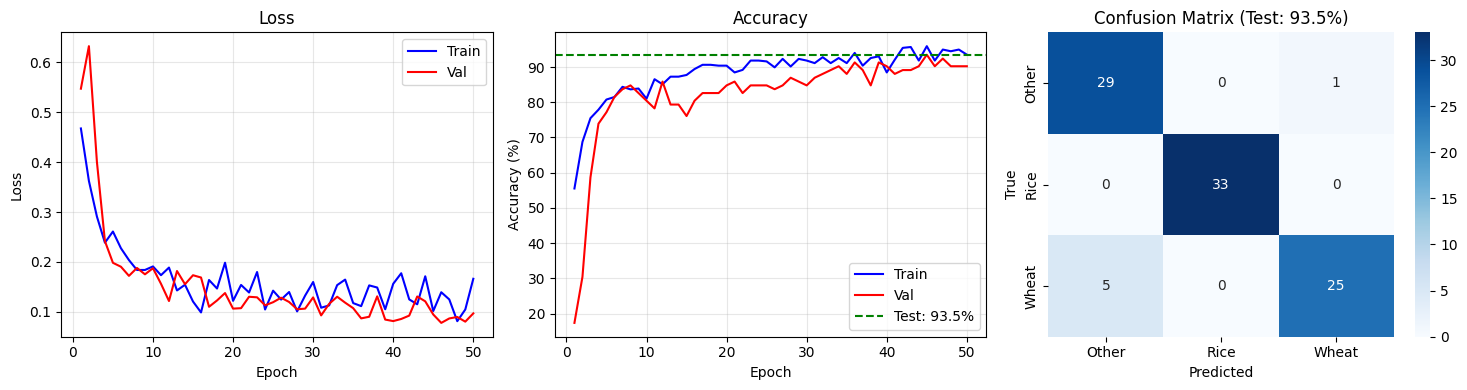

✓ Plot saved

✓ ALL DONE!

Files saved to: /content/drive/MyDrive/Pakistan_Models_v4
  • best_model_v4.pth
  • checkpoint_v4_ep*.pth
  • history_v4.json
  • results_v4.png

RESULTS:
  • Test Accuracy: 93.55%
  • Test F1 Score: 0.9330

IMPROVEMENTS in V4:
  • ResNet34 (larger model)
  • Label Smoothing (0.1)
  • Mixup Augmentation
  • Stronger Wheat augmentation
  • Test-Time Augmentation (TTA)
  • Higher Wheat class weight
  • Cosine Annealing with Warm Restarts



In [ ]:
# ╔═══════════════════════════════════════════════════════════════════════════╗
# ║  CELL 11: SAVE RESULTS                                                    ║
# ╚═══════════════════════════════════════════════════════════════════════════╝

print("\n" + "=" * 90)
print("CELL 11: SAVE RESULTS")
print("=" * 90)

import matplotlib.pyplot as plt
import seaborn as sns

# Save history
history_path = os.path.join(SAVE_DIR, "history_v4.json")
with open(history_path, 'w') as f:
    json.dump({
        'train_loss': [float(v) for v in history['train_loss']],
        'train_acc': [float(v) for v in history['train_acc']],
        'val_loss': [float(v) for v in history['val_loss']],
        'val_acc': [float(v) for v in history['val_acc']],
        'val_f1': [float(v) for v in history['val_f1']],
        'test_acc': float(test_acc),
        'test_f1': float(test_f1),
        'confusion_matrix': cm.tolist(),
    }, f, indent=2)
print(f"✓ History saved")

# Plot
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

epochs_range = range(1, len(history['train_loss']) + 1)

axes[0].plot(epochs_range, history['train_loss'], 'b-', label='Train')
axes[0].plot(epochs_range, history['val_loss'], 'r-', label='Val')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(epochs_range, history['train_acc'], 'b-', label='Train')
axes[1].plot(epochs_range, history['val_acc'], 'r-', label='Val')
axes[1].axhline(test_acc, color='g', linestyle='--', label=f'Test: {test_acc:.1f}%')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, ax=axes[2])
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('True')
axes[2].set_title(f'Confusion Matrix (Test: {test_acc:.1f}%)')

plt.tight_layout()
plot_path = os.path.join(SAVE_DIR, "results_v4.png")
plt.savefig(plot_path, dpi=150, bbox_inches='tight')
plt.show()
print(f"✓ Plot saved")

print(f"\n{'='*70}")
print("✓ ALL DONE!")
print(f"{'='*70}")
print(f"""
Files saved to: {SAVE_DIR}
  • best_model_v4.pth
  • checkpoint_v4_ep*.pth
  • history_v4.json
  • results_v4.png

RESULTS:
  • Test Accuracy: {test_acc:.2f}%
  • Test F1 Score: {test_f1:.4f}

IMPROVEMENTS in V4:
  • ResNet34 (larger model)
  • Label Smoothing (0.1)
  • Mixup Augmentation
  • Stronger Wheat augmentation
  • Test-Time Augmentation (TTA)
  • Higher Wheat class weight
  • Cosine Annealing with Warm Restarts
""")